In [1]:
# For running in colab
from google.colab import drive
drive.mount('/content/drive/')

import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment, it should be under CS354-Assignments-2022/netid-A1
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS6540-F24/Project' # change this directory to yours
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

sys.path.append(GOOGLE_DRIVE_PATH)

Mounted at /content/drive/
['constants.py', 'catagolue.parquet', 'image_classifier.py', '__pycache__', 'generate_worlds.py', 'world_catagolue.parquet', 'segment.ipynb']


In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import trange

In [3]:
from generate_worlds import load_world_df, truncate_labels, visualize_world
from pathlib import Path
import polars as pl

INPUT_PATH = Path('/content/drive/MyDrive/'+GOOGLE_DRIVE_PATH_AFTER_MYDRIVE+'/world_catagolue.parquet')
CATEGORY_COUNT = 4

if INPUT_PATH.exists():
      df = pl.read_parquet(INPUT_PATH)
else:
      print('No worlds file')

In [4]:
import numpy as np
# Load in the data into trainset and testset
def load_and_process_data(df):

  worlds = []
  labels = []


  num_items = 5000 # len(df) is too long! Uses too much RAM
  for idx in range(num_items):
    row = df[idx]
    if idx % 2 == 0:
      print(f'{idx}/{num_items}', end='')
    else:
      print('',end='\r')

    world = row['world pattern']
    label = row['tight label'][0].to_list()


    # Add the background
    label = np.array(label)
    label_shape = label.shape[1]
    background_label = np.full([label_shape, label_shape],1) - label[0] - label[1] - label[2] - label[3]
    new_label = np.zeros([5, label_shape, label_shape])

    new_label[0] = background_label
    new_label[1:] = label

    worlds.append(world)
    labels.append(new_label.tolist())

    ## Clean up to reduce RAM usage
    world = None
    label = None
    new_label = None
    background_label = None


  return worlds, labels

ws, ls = load_and_process_data(df)
## Clean up to reduce RAM usage
df = None

torch.Size([4000, 1, 64, 64])

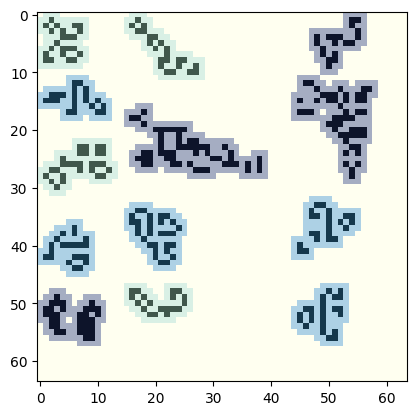

In [5]:
# Load in the training and testing data into distinct tensors

# Maybe get to  transforms later
# import torchvision.transforms as transforms

train_data = torch.Tensor(ws[0:4000])
train_labels = torch.Tensor(ls[0:4000])

test_data = torch.Tensor(ws[4000:])
test_labels = torch.Tensor(ls[4000:])

## Clean up to reduce RAM usage
ws = None
ls = None

# Test to make sure everything worked
d = train_data[5][0]
l = train_labels[5]


visualize_world(d, l)

train_data.shape
# train_labels.shape

In [6]:
# Create batches
BATCH_SIZE = 125
train_x_batch = train_data.split(BATCH_SIZE)
train_y_batch = train_labels.split(BATCH_SIZE)

test_x_batch = test_data.split(BATCH_SIZE)
test_y_batch = test_labels.split(BATCH_SIZE)

# More clean up
train_data = None
train_labels = None

test_data = None
test_labels = None

In [7]:
import warnings


# Torch fires this warning on every call to load_state_dict()
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

# Code adapted from the work done by user 'Nikdenof' from Medium
# https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239

# Which is in turn based on the paper
# SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation
# https://arxiv.org/pdf/1511.00561
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
    super(ConvBlock, self).__init__()
    self.stack = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

  def forward(self, x):
    return self.stack(x)

class EncoderBlock(nn.Module):
  # Creates an encoder block with [depth] convolution layers
  def __init__(self, in_channels, out_channels, depth=2, kernel_size=3, padding=1):
    super(EncoderBlock, self).__init__()
    self.layers = nn.ModuleList()
    for i in range(depth):
      self.layers.append(ConvBlock(in_channels, out_channels, kernel_size, padding))
      in_channels = out_channels
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    x, ind = self.pool(x)
    return x, ind

class DecoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels, depth=2, kernel_size=3, padding=1, classification=False):
    super(DecoderBlock, self).__init__()
    self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.layers = nn.ModuleList()
    # Recall that this is the decoder, so out_channels > in_channels
    for i in range(depth):
      if i == depth - 1:
        if classification:
          # Don't need BN or ReLU on the final layer
          self.layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
        else:
          # Expand at the final layer of the block
          self.layers.append(ConvBlock(in_channels, out_channels, kernel_size, padding))
      else:
        self.layers.append(ConvBlock(in_channels, in_channels, kernel_size, padding))

  def forward(self, x, ind):
    x = self.unpool(x, ind)
    for layer in self.layers:
      x = layer(x)
    return x

class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=32):
        super(SegNet, self).__init__()

        # Encoder
        self.enc0 = EncoderBlock(in_channels, features)
        self.enc1 = EncoderBlock(features, features * 4) # was *2
        # self.enc2 = EncoderBlock(features * 2, features * 4, depth=3)
        self.enc3 = EncoderBlock(features * 4, features * 8, depth=3)

        # Bottleneck
        self.bottleneck_enc = EncoderBlock(features * 8, features * 8, depth=3)
        self.bottleneck_dec = DecoderBlock(features * 8, features * 8, depth=3)

        # Decoder
        self.dec0 = DecoderBlock(features * 8, features * 4, depth=3)
        # self.dec1 = DecoderBlock(features * 4, features * 2, depth=3)
        self.dec2 = DecoderBlock(features * 4, features) # was *2
        self.dec3 = DecoderBlock(features, out_channels, classification=True) # Final layer classifies

    def forward(self, x):
        # encoder
        e0, ind0 = self.enc0(x)
        e1, ind1 = self.enc1(e0)
        # e2, ind2 = self.enc2(e1)
        e3, ind3 = self.enc3(e1)


        # bottleneck
        b0, indb = self.bottleneck_enc(e3)
        b1 = self.bottleneck_dec(b0, indb)



        # decoder
        d0 = self.dec0(b1, ind3)
        # d1 = self.dec1(d0, ind2)
        d2 = self.dec2(d0, ind1)


        # classification layer
        output = self.dec3(d2, ind0)

        return output

In [8]:
# Adapted from google AI for Jaccard Loss
def iou_loss(y_pred, y_true, smooth=1e-7):
    intersection = torch.sum(y_true * y_pred, dim=(1, 2))
    union = torch.sum(y_true, dim=(1, 2)) + torch.sum(y_pred, dim=(1, 2)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    loss = 1 - iou
    return loss.mean()

In [9]:
# To use GPU, you can set it in the menu "Runtime" - > "change runtime type"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Put the network on the GPU
segnet = SegNet(in_channels = 1, out_channels = 5)
# segnet = SegNet.to(device)

# This likely needs to change to some form of IoU
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(segnet.parameters(), lr = 0.001)

cpu


In [10]:
x = train_x_batch[0]
y = train_y_batch[0]

print(x.shape, y.shape)

out = segnet(x)
print(out.shape)

torch.Size([125, 1, 64, 64]) torch.Size([125, 5, 64, 64])
torch.Size([125, 5, 64, 64])


In [ ]:
# train MobileNet here.
segnet.train()

for epoch in range(5):  # Repeat multiple rounds
    for i, (inputs, labels) in enumerate(zip(train_x_batch, train_y_batch)):
        # inputs = inputs.to(device)
        # labels = labels.to(device)

        # add your code here ...
        optimizer.zero_grad()
        output = segnet(inputs)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # Output statistics
        if i % 5 == 0:
            print('Epoch: %d Batch: %5d loss: %.3f' %(epoch + 1, i + 1, loss.item()))

print('Finished Training')

Epoch: 1 Batch:     1 loss: 1.399
Epoch: 1 Batch:     6 loss: 0.861
Epoch: 1 Batch:    11 loss: 0.624
Epoch: 1 Batch:    16 loss: 0.535
Epoch: 1 Batch:    21 loss: 0.460


In [ ]:
def reconstruct(indices_tensor):
  x = indices_tensor.shape[-1]
  reconstructed_tensor = torch.zeros([5,x,x])

  for row_num, row in enumerate(indices_tensor):
    for col_num, col in enumerate(row):
      reconstructed_tensor[col, row_num,col_num] = 1
  return reconstructed_tensor

In [ ]:
torch.Tensor([[1,2],[3,4]]) * torch.Tensor([2,2])

In [ ]:
# Test SegNet here ...
num_batches = 0
total = torch.zeros(5)

for i, (inputs, y_true) in enumerate(zip(test_x_batch, test_y_batch)):

    # Make sure that the images and labels are on the same device as the model!
    inputs = inputs.to(device)
    y_true = labels.to(device)

    outputs = segnet(inputs)

    y_pred = torch.zeros(outputs.shape)
    for idx, out in enumerate(outputs):
      maxes = torch.max(out, 0)[1]
      y_pred[idx] = reconstruct(maxes)

    smooth = 1e-7

    intersection = torch.sum(y_true * y_pred, dim=(2, 3))
    union = torch.sum(y_true, dim=(2, 3)) + torch.sum(y_pred, dim=(2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)

    total += iou.mean(0)
    num_batches += 1
    print(f'Batch {num_batches} IOU: {iou.mean(0)}')

print('Mean IOU accuracy of the network: %.2f' % (
    total / num_batches))

In [ ]:
a = None

print(test_x_batch[0].shape)
segnet.eval()
a = segnet(test_x_batch[0])

for x in a[5:6]:
  print(x.shape)
  maxes = torch.max(x, 0)[1]
  recd = reconstruct(maxes)
  visualize_world(test_x_batch[0][5][0], recd)

a = None

In [ ]:
visualize_world(test_x_batch[0][5][0], test_y_batch[0][5])